# Mobilenet Based Model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import shutil
import json

## Input File

In [2]:
zip_path = '/content/archive.zip'
extract_path = '/content/dataset'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Ekstraksi selesai.")
else:
    print("File archive.zip tidak ditemukan. Silakan upload file terlebih dahulu.")

Ekstraksi selesai.


## Gabungkan data Augmentasi dan Original

In [3]:
original_base = '/content/dataset/Potato Disease Recognition Dataset/Original Images/Original Images'
augmented_base = '/content/dataset/Potato Disease Recognition Dataset/Augmented Images/Augmented Images'
combined_base = '/content/combined_dataset'

classes = [
    'Potato Soft Rot Disease',
    'Potato Dry Rot Disease',
    'Potato Brown Rot Disease',
    'Healthy Potato',
    'Blackspot Bruising Disease'
]

# Proses penggabungan
for cls in classes:
    os.makedirs(os.path.join(combined_base, cls), exist_ok=True)

    orig_folder = os.path.join(original_base, cls)
    aug_folder = os.path.join(augmented_base, f"Augmented {cls}")

    if os.path.exists(orig_folder):
        for img in os.listdir(orig_folder):
            shutil.copy(os.path.join(orig_folder, img), os.path.join(combined_base, cls, f"orig_{img}"))

    if os.path.exists(aug_folder):
        for img in os.listdir(aug_folder):
            shutil.copy(os.path.join(aug_folder, img), os.path.join(combined_base, cls, f"aug_{img}"))

print(f"Dataset berhasil digabung di: {combined_base}")

Dataset berhasil digabung di: /content/combined_dataset


In [4]:
batch_size = 32
img_size = (224, 224) # Standar MobileNetV2

train_ds = tf.keras.utils.image_dataset_from_directory(
    combined_base,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    combined_base,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names

Found 3960 files belonging to 5 classes.
Using 3168 files for training.
Found 3960 files belonging to 5 classes.
Using 792 files for validation.


## Buat Model MobilenetV2

In [14]:
# 1. Base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# 2. Definisikan Input secara eksplisit
inputs = tf.keras.Input(shape=(224, 224, 3))

# 3. Alurkan data (Functional API)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

# 4. Buat Model
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## Training model

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20 # Biasanya 10 epoch sudah sangat bagus untuk MobileNet
)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.4608 - loss: 1.3372 - val_accuracy: 0.6818 - val_loss: 0.7873
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6470 - loss: 0.8679 - val_accuracy: 0.7109 - val_loss: 0.6941
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6885 - loss: 0.7541 - val_accuracy: 0.6780 - val_loss: 0.7182
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.7239 - loss: 0.6944 - val_accuracy: 0.7184 - val_loss: 0.6497
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7363 - loss: 0.6589 - val_accuracy: 0.7449 - val_loss: 0.6163
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.7550 - loss: 0.6039 - val_accuracy: 0.7652 - val_loss: 0.5966
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.7727 - loss: 0.5658 - val_accuracy: 0.7412 - val_loss: 0.6041
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7840 - loss: 0.5519 - val_accuracy: 0.75

## Evaluasi

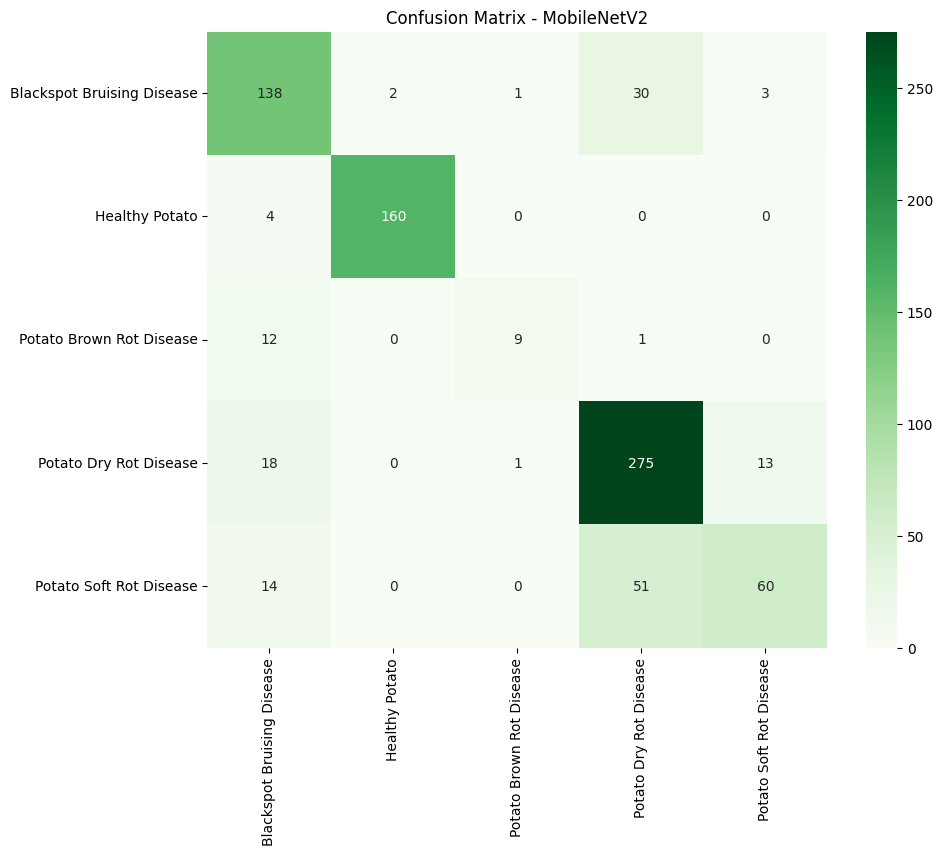


Classification Report:
                            precision    recall  f1-score   support

Blackspot Bruising Disease       0.74      0.79      0.77       174
            Healthy Potato       0.99      0.98      0.98       164
  Potato Brown Rot Disease       0.82      0.41      0.55        22
    Potato Dry Rot Disease       0.77      0.90      0.83       307
   Potato Soft Rot Disease       0.79      0.48      0.60       125

                  accuracy                           0.81       792
                 macro avg       0.82      0.71      0.74       792
              weighted avg       0.81      0.81      0.80       792



In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true, y_pred = [], []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - MobileNetV2')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

## Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


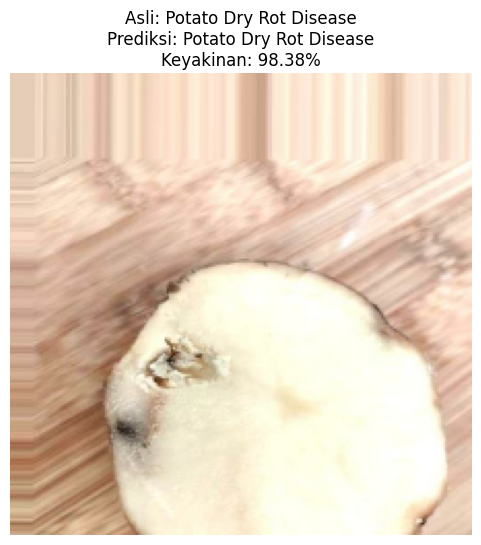

✅ Prediksi Benar!


In [23]:
import numpy as np

# 1. Ambil satu batch (isi 32 gambar) dari data validasi
images, labels = next(iter(val_ds))

# 2. Pilih indeks acak dari batch tersebut
index = np.random.randint(0, len(images))
test_image = images[index].numpy().astype("uint8")
true_label = class_names[labels[index]]

# 3. Lakukan prediksi
# Kita perlu menambah dimensi batch (1, 224, 224, 3) agar bisa diproses model
img_array = tf.expand_dims(images[index], 0)
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]
confidence = 100 * np.max(predictions)

# 4. Tampilkan Hasil
plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.title(f"Asli: {true_label}\nPrediksi: {predicted_class}\nKeyakinan: {confidence:.2f}%")
plt.axis("off")
plt.show()

if true_label == predicted_class:
    print("✅ Prediksi Benar!")
else:
    print("❌ Prediksi Salah.")

## Save Model

In [11]:
model.save('potato_mobilenet_model.h5')

with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

from google.colab import files
files.download('potato_mobilenet_model.h5')
files.download('class_names.json')
print("Model dan Class Names siap diunduh!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model dan Class Names siap diunduh!


In [24]:
# Simpan dengan ekstensi .keras (bukan .h5)
model.save('potato_mobilenet_model.keras')

from google.colab import files
files.download('potato_mobilenet_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>